# Can you speak like a violin ?
## Build a simple VAE
author : Côme Peladeau (peladeau@ircam.fr)

In [1]:
import torch
import torch.nn as nn
import torch.distributions as distrib
import torchvision
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('dark_background')
device  = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
from torch.utils.tensorboard import SummaryWriter
#device = "cpu"
print(device)
from IPython.display import display, Audio

cuda:0


### Develop your very own VAE


As we have seen, VAEs can be simply implemented by decomposing the above series of operations into an `encoder` which represents the distribution $q_\phi(\mathbf{z}\vert\mathbf{x})$, from which we will sample some values $\tilde{\mathbf{z}}$ (using the reparametrization trick) and compute the Kullback-Leibler (KL) divergence. Then, we use these values as input to a `decoder` which represents the distribution $p_\theta(\mathbf{x}\vert\mathbf{z})$ so that we can produce a reconstruction $\tilde{\mathbf{x}}$ and compute the reconstruction error. 

Therefore, we can define the VAE based on our previous implementation of the AE that we recall here

In [2]:
class AE(nn.Module):
    def __init__(self, encoder, decoder, encoding_dim):
        super(AE, self).__init__()
        self.encoding_dims = encoding_dim
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In order to move to a probabilistic version, we need to add the latent space sampling mechanism, and change the behavior of our `call` function. This process is implemented in the following `VAE` class.

Note that we purposedly rely on an implementation of the `encode` function where the `encoder` first produces an intermediate representation of size `encoder_dims`. Then, this representation goes through two separate functions for encoding $\mathbf{\mu}$ and $\mathbf{\sigma}$. This provides a clearer implementation but also the added bonus that we can ensure that $\mathbf{\sigma} > 0$

$$
D_{KL} \big[ q_\phi(\mathbf{z|x}) \parallel \mathcal{N}(\mathbf{0}, \mathbf{I}) \big] = \frac{1}{2}\sum_{j=1}^{D}\left(1+\text{log}((\sigma^{(i)}_j)^2)+(\mu^{(i)}_j)^2+(\sigma^{(i)}_j)^2\right)
\tag{6}
$$

In [3]:
class VAE(AE):
    
    def __init__(self, encoder, decoder, encoding_dims, latent_dims):
        super(VAE, self).__init__(encoder, decoder, encoding_dims)
        self.latent_dims = latent_dims
        self.mu = nn.Linear(self.encoding_dims, self.latent_dims)
        self.sigma = nn.Sequential(nn.Linear(self.encoding_dims, self.latent_dims), nn.Softplus())
        
    def encode(self, x):
        encoded = encoder(x)
        mu = self.mu(encoded)
        sigma = self.sigma(encoded)
        return mu, sigma
    
    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        # Encode the inputs
        z_params = self.encode(x)
        # Obtain latent samples and latent loss
        z_tilde, kl_div = self.latent(x, z_params)
        # Decode the samples
        x_tilde = self.decode(z_tilde)
        return x_tilde.reshape(-1, 1, 28, 28), kl_div
    
    def latent(self, x, z_params):
        z = z_params[0] + torch.randn(self.latent_dims).to(device)*torch.square(z_params[1])
        kl_div = (1 + torch.log(torch.square(z_params[1])) - torch.square(z_params[0]) - torch.square(z_params[1]))/2
        return z, kl_div

Now the interesting aspect of VAEs is that we can define any parametric function as `encoder` and `decoder`, as long as we can optimize them. Here, we will rely on simple feed-forward neural networks, but these can be largely more complex (with limitations that we will discuss later in the tutorial).

In [4]:
class Decoder(nn.Module):
    def __init__(self, nin, n_latent = 16, n_hidden = 512, n_classes = 1,conv_channels = 1):
        super(Decoder, self).__init__()
        self.conv_channels = conv_channels
        self.Lin1 = nn.Linear(n_latent, n_hidden)
        self.Lin2 = nn.Linear(n_hidden, ((28-8)**2)*32)
        self.ConvT1 = nn.ConvTranspose2d(32, 16, 5, stride = 1)
        self.ConvT2 = nn.ConvTranspose2d(16, 1, 5, stride = 1)
        self.ReLU = nn.ReLU()
        self.Sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        h = self.ReLU(self.Lin1(x))
        h = self.ReLU(self.Lin2(h))
        h = h.reshape(-1, 32, 28-8, 28-8)
        #h = self.ReLU(self.ConvT1(h))
        h = self.ReLU(self.ConvT1(h))
        x_hat = self.Sigmoid(self.ConvT2(h))
        return x_hat
        
        

def construct_encoder_decoder(nin, n_latent = 16, n_hidden = 512, n_classes = 1,conv_channels = 1):
    # Encoder network
    encoder = nn.Sequential(
        nn.Conv2d(1, 16, 5, stride = 1), nn.ReLU(),
        nn.Conv2d(16, 32, 5, stride = 1), nn.ReLU(),
        #nn.Conv2d(conv_channels,conv_channels,3,padding = 1), nn.ReLU(),
        nn.Flatten(),
        nn.Linear(((28-8)**2)*32, n_hidden), nn.ReLU(),
        #nn.Linear(n_hidden, n_hidden), nn.ReLU(),
    )
    # Decoder network
    decoder = Decoder(nin = nin,n_latent = n_latent, n_classes=n_classes,conv_channels = conv_channels)
    return encoder, decoder

### Evaluating the error

In the definition of the `VAE` class, we directly included the computation of the $D_{KL}$ term to regularize our latent space. However, remember that the complete loss of equation (4) also contains a *reconstruction loss* which compares our reconstructed output to the original data. 

While there are several options to compare the error between two elements, there are usually two preferred choices among the generative literature depending on how we consider our problem
1. If we consider each dimension (pixel) to be a binary unit (following a Bernoulli distribution), we can rely on the `binary cross entropy` between the two distributions
2. If we turn our problem to a set of classifications, where each dimension can belong to a given set of *intensity classes*, then we can compute the `multinomial loss` between the two distributions

In the following, we define both error functions and regroup them in the `reconstruction_loss` call (depending on the `num_classes` considered). However, as the `multinomial loss` requires a large computational overhead, and for the sake of simplicity, we will train all our first models by relying on the `binary cross entropy`

In [5]:
# Reconstruction criterion
recons_criterion = torch.nn.MSELoss(reduction='none').to(device)

def compute_loss(model, x):
    x_hat, kl_div = model(x)
    full_loss = recons_criterion(x_hat,x).mean(0).sum()-kl_div.mean(0).sum()
    return full_loss

def train_step(model, x, optimizer):
    # Compute the loss.
    model = model.to(device)
    x = x.to(device)
    loss = compute_loss(model, x)
    # Before the backward pass, zero all of the network gradients
    optimizer.zero_grad()
    # Backward pass: compute gradient of the loss with respect to parameters
    loss.backward()
    # Calling the step function to update the parameters
    optimizer.step()
    return loss

### Optimizing a VAE on a real dataset

For this tutorial, we are going to take a quick shot at a real-life problem by trying to train our VAEs on the `FashionMNIST` dataset. This dataset can be natively used in PyTorch by relying on the `torchvision.datasets` classes as follows

In [6]:
dataset_dir = './data'
# Going to use 80%/20% split for train/valid
valid_ratio = 0.2
# Load the dataset for the training/validation sets
train_valid_dataset = torchvision.datasets.MNIST(root=dataset_dir, train=True, transform=torchvision.transforms.ToTensor(), download=True)
# Split it into training and validation sets
nb_train = int((1.0 - valid_ratio) * len(train_valid_dataset))
nb_valid =  int(valid_ratio * len(train_valid_dataset))
train_dataset, valid_dataset = torch.utils.data.dataset.random_split(train_valid_dataset, [nb_train, nb_valid])
# Load the test set
test_dataset = torchvision.datasets.MNIST(root=dataset_dir, transform=torchvision.transforms.ToTensor(),train=False)
# Prepare 
num_threads = 0     # Loading the dataset is using 4 CPU threads
batch_size  = 128   # Using minibatches of 128 samples
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=num_threads)
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_threads)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,batch_size=batch_size,shuffle=False,num_workers=num_threads)

The `FashionMNIST` dataset is composed of simple 28x28 black and white images of different items of clothings (such as shoes, bags, pants and shirts). We put a simple function here to display one batch of the test set (note that we keep a fixed batch from the test set in order to evaluate the different variations that we will try in this tutorial).

The train set contains 48000 images, in 375 batches
The validation set contains 12000 images, in 94 batches
The test set contains 10000 images, in 79 batches


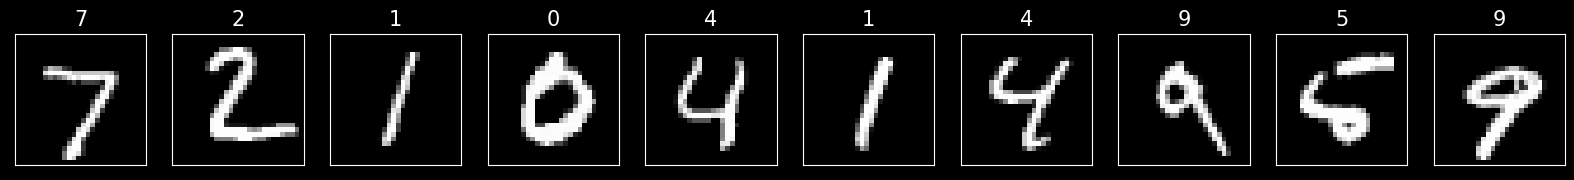

In [7]:
print("The train set contains {} images, in {} batches".format(len(train_loader.dataset), len(train_loader)))
print("The validation set contains {} images, in {} batches".format(len(valid_loader.dataset), len(valid_loader)))
print("The test set contains {} images, in {} batches".format(len(test_loader.dataset), len(test_loader)))
nsamples = 10
imgs_test, labels = next(iter(test_loader))
fig = plt.figure(figsize=(20,5))
for i in range(nsamples):
    ax = plt.subplot(1,nsamples, i+1)
    plt.imshow(imgs_test[i, 0, :, :], vmin=0, vmax=1.0, cmap=matplotlib.cm.gray)
    ax.set_title("{}".format(labels[i]), fontsize=15)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

Now based on our proposed implementation, the optimization aspects are defined in a very usual way

In [8]:
# Using Bernoulli or Multinomial loss
num_classes = 1
# Number of hidden and latent
n_hidden = 512
n_latent = 2
# Compute input dimensionality
nin = imgs_test.shape[2] * imgs_test.shape[3]
# Construct encoder and decoder
encoder, decoder = construct_encoder_decoder(nin, n_hidden = n_hidden, n_latent = n_latent, n_classes = num_classes,conv_channels = 5)
# Build the VAE model
model = VAE(encoder, decoder, n_hidden, n_latent)

In [9]:
# Construct the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

### Training using BCELoss

Now all that is left to do is train the model. We define here a `train_vae` function that we will reuse along the future implementations and variations of VAEs and flows. Note that this function is set to run for only a very few number of `epochs` and also most importantly, *only considers a subsample of the full dataset at each epoch*. This option is just here so that you can test the different models very quickly on any CPU or laptop.

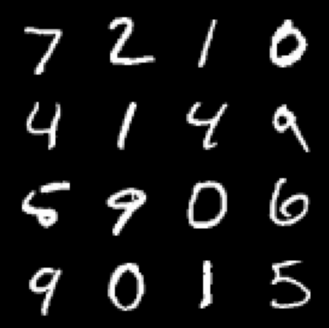

Epoch: 5, Test set ELBO: tensor([15245.3281], device='cuda:0', grad_fn=<AddBackward0>)


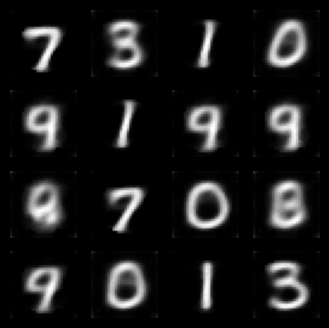

Epoch: 10, Test set ELBO: tensor([14013.8184], device='cuda:0', grad_fn=<AddBackward0>)


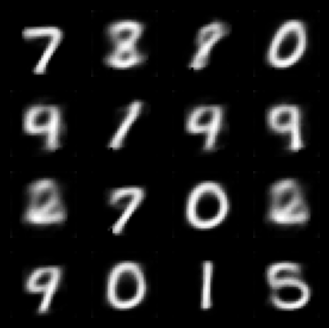

Epoch: 15, Test set ELBO: tensor([13380.6631], device='cuda:0', grad_fn=<AddBackward0>)


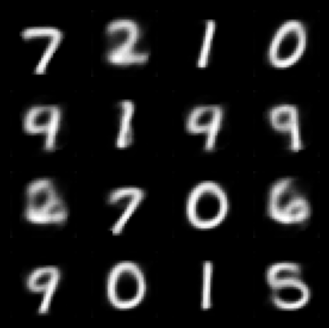

Epoch: 20, Test set ELBO: tensor([13021.8408], device='cuda:0', grad_fn=<AddBackward0>)


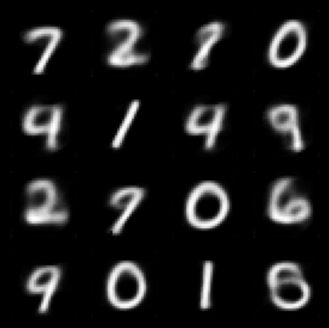

Epoch: 25, Test set ELBO: tensor([12713.4170], device='cuda:0', grad_fn=<AddBackward0>)


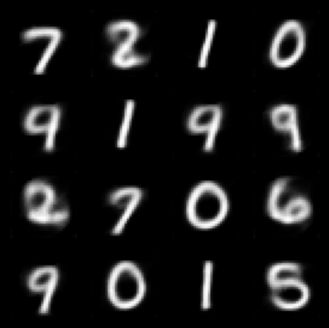

Epoch: 30, Test set ELBO: tensor([12508.4707], device='cuda:0', grad_fn=<AddBackward0>)


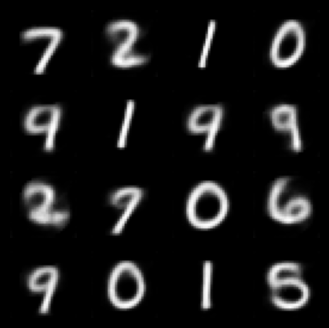

Epoch: 35, Test set ELBO: tensor([12347.4404], device='cuda:0', grad_fn=<AddBackward0>)


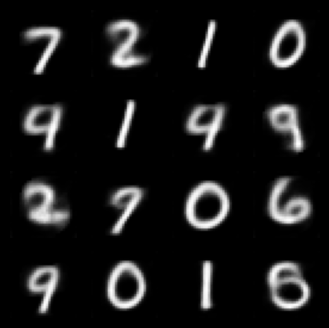

Epoch: 40, Test set ELBO: tensor([12209.9238], device='cuda:0', grad_fn=<AddBackward0>)


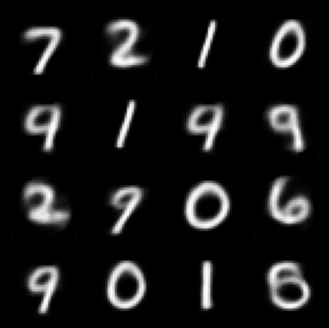

Epoch: 45, Test set ELBO: tensor([12079.8506], device='cuda:0', grad_fn=<AddBackward0>)


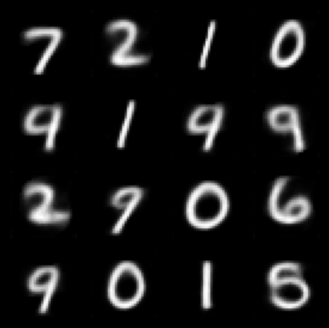

Epoch: 50, Test set ELBO: tensor([11983.2148], device='cuda:0', grad_fn=<AddBackward0>)


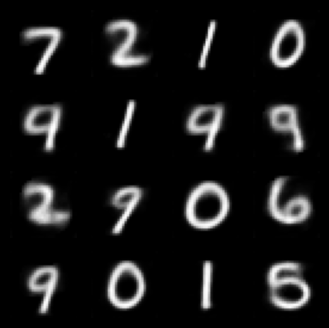

In [10]:
def generate_and_save_images(model, epoch, test_sample):
    predictions, _ = model(test_sample.to(device))
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, 0, :, :].cpu().detach(), cmap='gray')
        plt.axis('off')
    # Tight_layout minimizes the overlap between 2 sub-plots
    #plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

#writer = SummaryWriter()


epochs=50
test_sample = imgs_test[0:16, :, :, :].to(device)

fig = plt.figure(figsize=(4, 4))
for i in range(test_sample.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(imgs_test[i, 0, :, :].cpu().detach(), cmap='gray')
    plt.axis('off')
# Tight_layout minimizes the overlap between 2 sub-plots
#plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
plt.show()


for epoch in range(1, epochs + 1):
    full_loss = torch.Tensor([0]).to(device)
    # Forward pass: compute predicted y by passing x to the model.
    for i, (x, _) in enumerate(train_loader):
        full_loss += train_step(model, x, optimizer)
    #for i, (x, _) in enumerate(valid_loader):
    #    train_step(model, x, optimizer)
    if epoch%5==0:
        print('Epoch: {}, Test set ELBO: {}'.format(epoch, full_loss))
        #grid = torchvision.utils.make_grid(test_sample)
        #writer.add_image('images', grid, 0)
        #writer.add_image(test_sample, test_sample)
        #writer.close()
        generate_and_save_images(model, epoch, test_sample)

### Evaluating generative models

In order to evaluate our upcoming generative models, we will rely on the computation of the Negative Log-Likelihood. This code for the following `evaluate_nll_bpd` is inspired by the [Sylvester flow repository](https://github.com/riannevdberg/sylvester-flows)

Now we can evaluate our VAE model more formally as follows.

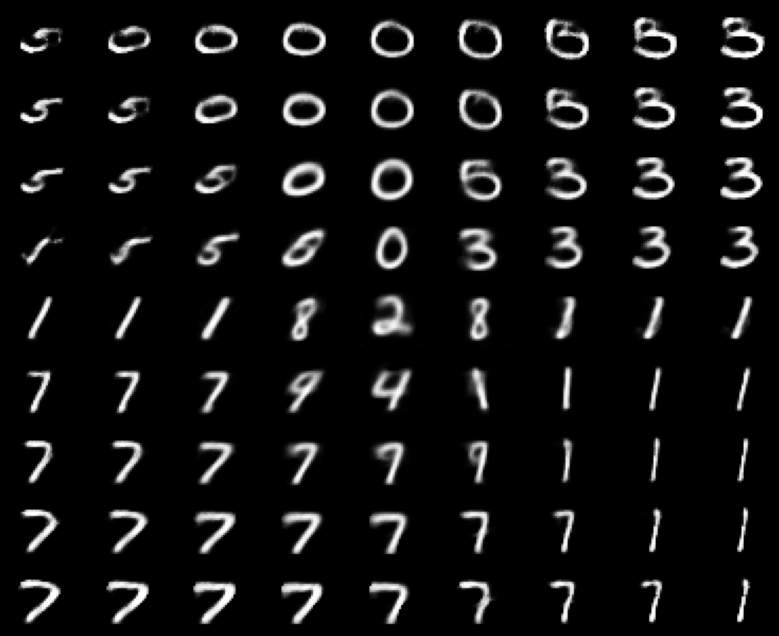

In [11]:
x = np.linspace(-3, 3, 9)
y = np.linspace(-3, 3, 9)
fig = plt.figure(figsize=(10, 8))
for i in range(9):
    for j in range(9):
        plt.subplot(9, 9, (i * 9) + j + 1)
        final_tensor = torch.zeros(2)
        final_tensor[0] = x[i]
        final_tensor[1] = y[j]
        plt.imshow(model.decode(final_tensor.to(device)).cpu().detach().reshape(28, 28), cmap='gray')
        plt.axis('off')

In [12]:
def compute_loss_beta(model, x, beta):
    x_hat, kl_div = model(x)
    full_loss = recons_criterion(x_hat,x).mean(0).sum() - beta*(kl_div.mean(0).sum())
    return full_loss

def train_step_beta(model, x, optimizer, beta):
    # Compute the loss.
    model = model.to(device)
    x = x.to(device)
    loss = compute_loss_beta(model, x, beta)
    # Before the backward pass, zero all of the network gradients
    optimizer.zero_grad()
    # Backward pass: compute gradient of the loss with respect to parameters
    loss.backward()
    # Calling the step function to update the parameters
    optimizer.step()
    return loss

In [13]:
# Using Bernoulli or Multinomial loss
num_classes = 1
# Number of hidden and latent
n_hidden = 512
n_latent = 2
# Compute input dimensionality
nin = imgs_test.shape[2] * imgs_test.shape[3]
# Construct encoder and decoder
encoder, decoder = construct_encoder_decoder(nin, n_hidden = n_hidden, n_latent = n_latent, n_classes = num_classes,conv_channels = 5)
# Build the VAE model
model = VAE(encoder, decoder, n_hidden, n_latent)

In [14]:
# Construct the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

### Training using BCELoss and warm up procedure

Now all that is left to do is train the model. We define here a `train_vae` function that we will reuse along the future implementations and variations of VAEs and flows. Note that this function is set to run for only a very few number of `epochs` and also most importantly, *only considers a subsample of the full dataset at each epoch*. This option is just here so that you can test the different models very quickly on any CPU or laptop.

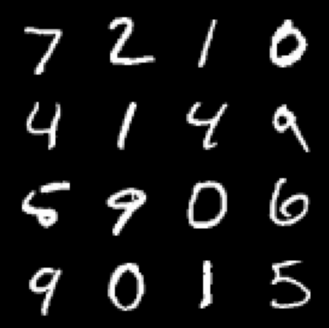

Epoch: 5, Test set ELBO: tensor([15552.7266], device='cuda:0', grad_fn=<AddBackward0>), beta : 0.16666666666666666


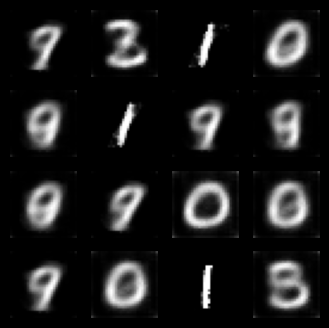

Epoch: 10, Test set ELBO: tensor([14163.1094], device='cuda:0', grad_fn=<AddBackward0>), beta : 0.3333333333333333


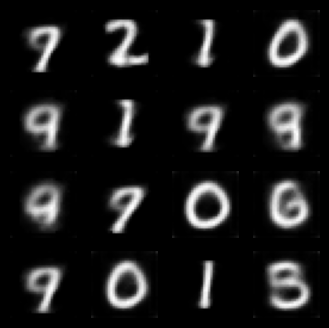

Epoch: 15, Test set ELBO: tensor([13414.6396], device='cuda:0', grad_fn=<AddBackward0>), beta : 0.5


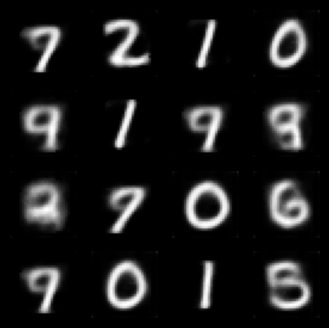

Epoch: 20, Test set ELBO: tensor([13075.1816], device='cuda:0', grad_fn=<AddBackward0>), beta : 0.6666666666666666


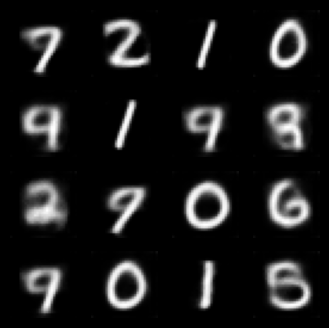

Epoch: 25, Test set ELBO: tensor([12940.9951], device='cuda:0', grad_fn=<AddBackward0>), beta : 0.8333333333333334


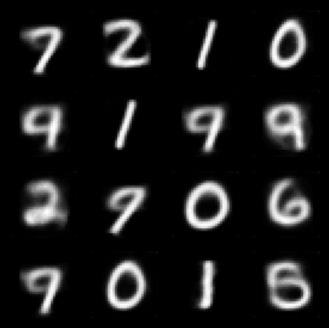

Epoch: 30, Test set ELBO: tensor([12907.6572], device='cuda:0', grad_fn=<AddBackward0>), beta : 1


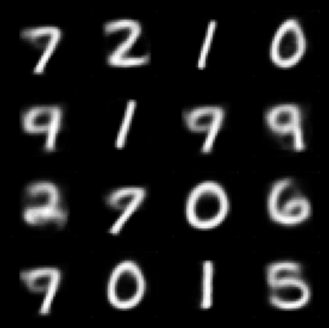

Epoch: 35, Test set ELBO: tensor([12734.9307], device='cuda:0', grad_fn=<AddBackward0>), beta : 1


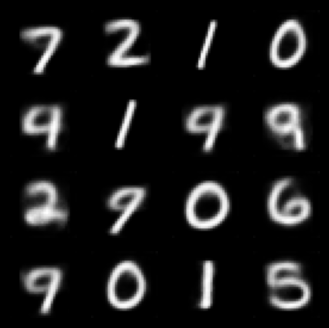

Epoch: 40, Test set ELBO: tensor([12587.6631], device='cuda:0', grad_fn=<AddBackward0>), beta : 1


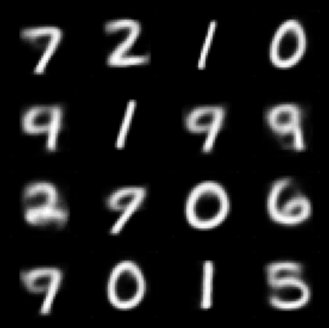

Epoch: 45, Test set ELBO: tensor([12438.5039], device='cuda:0', grad_fn=<AddBackward0>), beta : 1


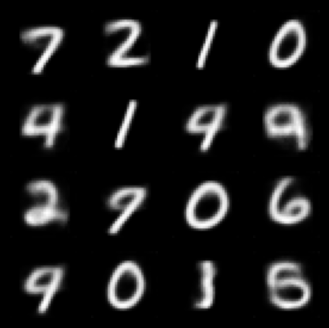

Epoch: 50, Test set ELBO: tensor([12320.2910], device='cuda:0', grad_fn=<AddBackward0>), beta : 1


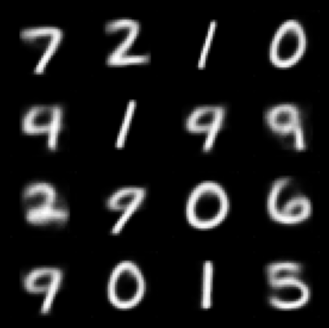

In [15]:
def generate_and_save_images(model, epoch, test_sample):
    predictions, _ = model(test_sample.to(device))
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, 0, :, :].cpu().detach(), cmap='gray')
        plt.axis('off')
    # Tight_layout minimizes the overlap between 2 sub-plots
    #plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

#writer = SummaryWriter()

#Warm up
N_warm_up = 30
beta_end = 1


epochs=50
test_sample = imgs_test[0:16, :, :, :].to(device)

fig = plt.figure(figsize=(4, 4))
for i in range(test_sample.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(imgs_test[i, 0, :, :].cpu().detach(), cmap='gray')
    plt.axis('off')
# Tight_layout minimizes the overlap between 2 sub-plots
#plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
plt.show()

for epoch in range(1, epochs + 1):
    full_loss = torch.Tensor([0]).to(device)
    
    if epoch<N_warm_up:
        beta = beta_end*epoch/N_warm_up
    else:
        beta = beta_end
    # Forward pass: compute predicted y by passing x to the model.
    for i, (x, _) in enumerate(train_loader):
        full_loss += train_step_beta(model, x, optimizer, beta)
    #for i, (x, _) in enumerate(valid_loader):
    #    train_step(model, x, optimizer)
    if epoch%5==0:
        print('Epoch: {}, Test set ELBO: {}, beta : {}'.format(epoch, full_loss, beta))
        #grid = torchvision.utils.make_grid(test_sample)
        #writer.add_image('images', grid, 0)
        #writer.add_image(test_sample, test_sample)
        #writer.close()
        generate_and_save_images(model, epoch, test_sample)

torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Si

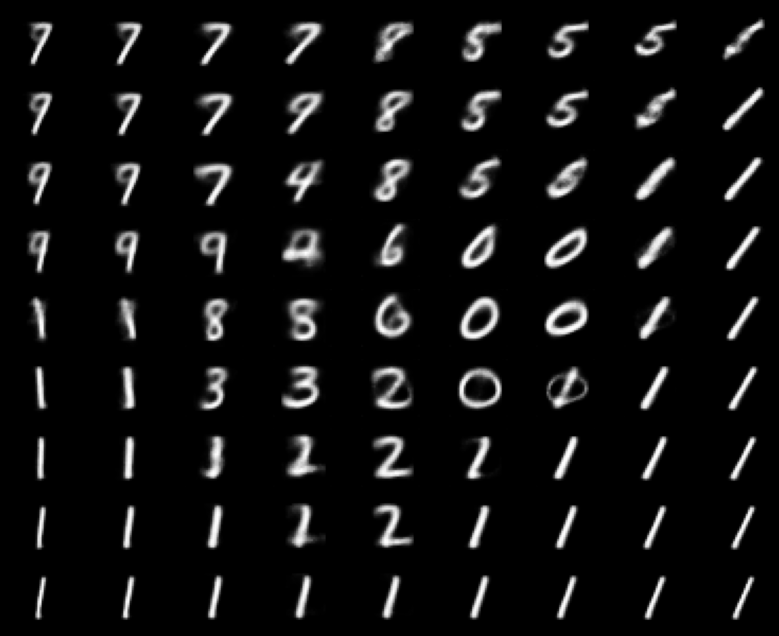

In [58]:
x = np.linspace(-2, 2, 9)
y = np.linspace(-2, 2, 9)
fig = plt.figure(figsize=(10, 8))
for i in range(9):
    for j in range(9):
        plt.subplot(9, 9, (i * 9) + j + 1)
        final_tensor = torch.zeros(2)
        final_tensor[0] = x[i]
        final_tensor[1] = y[j]
        print(final_tensor.size())
        plt.imshow(model.decode(final_tensor.to(device)).cpu().detach().reshape(28, 28), cmap='gray')
        plt.axis('off')

### Interpolating in the latent space

tensor(7)
tensor(2)
torch.Size([1, 1, 28, 28])
torch.Size([15, 1, 28, 28])


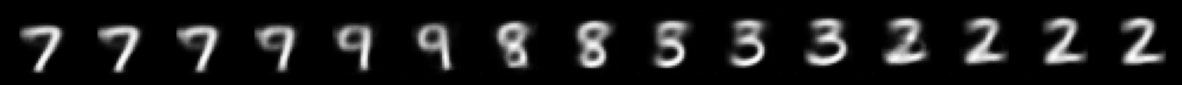

In [89]:
def interpol_lin(model,x1,x2,n_steps):
    x1 = x1.to(device)
    x2 = x2.to(device)
    model = model.to(device)
    mu1,eps1 = model.encode(x1)
    mu2,eps2 = model.encode(x2)
    mu_int = mu1
    for n in range(1,n_steps):
        mu_int = torch.concat((mu_int, n/(n_steps-1)*mu2 + (n_steps-1-n)/(n_steps-1)*mu1))
    imgs_out = model.decode(mu_int)
    return imgs_out

n_images = 15

imgs_test, labels = next(iter(test_loader))
print(labels[0])
print(labels[1])

img0 = imgs_test[0,:,:,:].reshape(1,1,28,28)
img1 = imgs_test[1,:,:,:].reshape(1,1,28,28)
print(img0.size())
imgs_inter = interpol_lin(model,img0,img1,n_images)

print(imgs_inter.size())

fig = plt.figure(figsize=(n_images, 1))
for i in range(n_images):
    plt.subplot(1, n_images, i + 1)
    plt.imshow(imgs_inter[i, 0, :, :].cpu().detach(), cmap='gray')
    plt.axis('off')


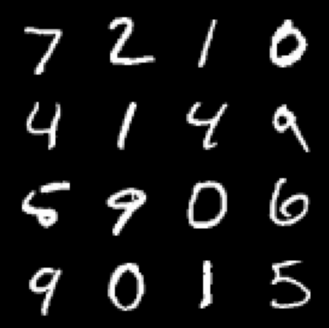

In [90]:

fig = plt.figure(figsize=(4, 4))
for i in range(test_sample.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(imgs_test[i, 0, :, :].cpu().detach(), cmap='gray')
    plt.axis('off')
# Tight_layout minimizes the overlap between 2 sub-plots
#plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
plt.show()